# Introduction to Artificial Neural Networks

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

This notebook is an introduction to the fundamental model/paradigm behind deep learning: the artificial neural network

Artificial neural networks (ANNs) are software implementations of the neuronal structure of our brains.  We don’t need to talk about the complex biology of our brain structures, but suffice to say, the brain contains neurons which are kind of like organic switches.  These can change their output state depending on the strength of their electrical or chemical input.  The neural network in a person’s brain is a hugely interconnected network of neurons, where the output of any given neuron may be the input to thousands of other neurons.  Learning occurs by repeatedly activating certain neural connections over others, and this reinforces those connections.  This makes them more likely to produce a desired outcome given a specified input.  This learning involves feedback – when the desired outcome occurs, the neural connections causing that outcome become strengthened.


Artificial neural networks attempt to simplify and mimic this brain behaviour.  They can be trained in a supervised or unsupervised manner.  In a supervised ANN, the network is trained by providing matched input and output data samples, with the intention of getting the ANN to provide a desired output for a given input.  An example is an e-mail spam filter – the input training data could be the count of various words in the body of the e-mail, and the output training data would be a classification of whether the e-mail was truly spam or not.  If many examples of e-mails are passed through the neural network this allows the network to learn what input data makes it likely that an e-mail is spam or not.  This learning takes place be adjusting the weights of the ANN connections, but this will be discussed further in the next section.

First, load the usual libraries

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from skimage.transform import resize
from imageio import imread
from skimage import color

In [2]:
import s3fs
fs = s3fs.S3FileSystem(anon=True)

## Constructing a multi-class neural network classifier

### Preparing a data set

Let's take a look at some data

In [27]:
cats = [f for f in fs.ls('cdi-workshop/imrecog_data/EuroSAT')][:10]
cats

['cdi-workshop/imrecog_data/EuroSAT/AnnualCrop',
 'cdi-workshop/imrecog_data/EuroSAT/Forest',
 'cdi-workshop/imrecog_data/EuroSAT/HerbaceousVegetation',
 'cdi-workshop/imrecog_data/EuroSAT/Highway',
 'cdi-workshop/imrecog_data/EuroSAT/Industrial',
 'cdi-workshop/imrecog_data/EuroSAT/Pasture',
 'cdi-workshop/imrecog_data/EuroSAT/PermanentCrop',
 'cdi-workshop/imrecog_data/EuroSAT/Residential',
 'cdi-workshop/imrecog_data/EuroSAT/River',
 'cdi-workshop/imrecog_data/EuroSAT/SeaLake']

Let's specify the number of images per category we want to train with, and the size of the images we want to train with

In [28]:
number_per_cat = 200
size = 64

Here we will read each image into a list, convert to greyscale, resize it, and keep track of its label 

In [29]:
images = []
labels = []
counter = 0
for cat in cats:
    print(cat)
    files = [f for f in fs.ls(cat) if f.endswith('.jpg')][:number_per_cat]
    for file in files:
        with fs.open(file, 'rb') as f:
            images.append(resize(color.rgb2gray(imread(f, 'jpg')), (size, size)).flatten())
            labels.append(counter)
    counter += 1            

cdi-workshop/imrecog_data/EuroSAT/AnnualCrop


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


cdi-workshop/imrecog_data/EuroSAT/Forest
cdi-workshop/imrecog_data/EuroSAT/HerbaceousVegetation
cdi-workshop/imrecog_data/EuroSAT/Highway
cdi-workshop/imrecog_data/EuroSAT/Industrial
cdi-workshop/imrecog_data/EuroSAT/Pasture
cdi-workshop/imrecog_data/EuroSAT/PermanentCrop
cdi-workshop/imrecog_data/EuroSAT/Residential
cdi-workshop/imrecog_data/EuroSAT/River
cdi-workshop/imrecog_data/EuroSAT/SeaLake


In [30]:
images = np.asarray(images)
print(images.shape)

(2000, 4096)


We can view an individual image to check it

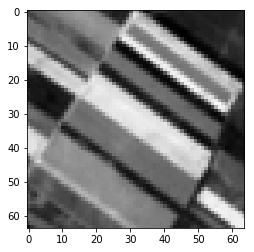

In [31]:
plt.imshow(images[0].reshape(64,64), cmap='gray')

It’s standard practice to scale the input data so that it all fits mostly between either 0 to 1 or with a small range centred around 0 i.e. -1 to 1.  

Why?  It can help the convergence of the neural network and is especially important if we are combining different data types.

The scikit learn standard scaler by default normalises the data by subtracting the mean and dividing by the standard deviation. 

In [32]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(images)

In [33]:
np.shape(X)

(2000, 4096)

In machine learning, there is a phenomenon called “overfitting”. This occurs when models, during training, become too complex – they become really well adapted to predict the training data, but when they are asked to predict something based on new data that they haven’t “seen” before, they perform poorly. In other words, the models don’t generalise very well. To make sure that we are not creating models which are too complex, it is common practice to split the dataset into a training set and a test set. The training set is, obviously, the data that the model will be trained on, and the test set is the data that the model will be tested on after it has been trained. The amount of training data is always more numerous than the testing data, and is usually between 60-80% of the total dataset.

In [34]:
from sklearn.model_selection import train_test_split
y = labels 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
np.shape(X_train)

(1600, 4096)

In [36]:
num_cats = len(np.unique(labels))

### Setting up the network

neural network architecture would be to have an output layer of 5 nodes, with each of these nodes representing a label from 0 to 4. 

We want to train the network so that when, say, an image of the digit “1” is presented to the neural network, the node in the output layer representing 1 has the highest value. 

like this: [0, 1, 0, 0, 0, 0]. 

In [37]:
def convert_y_to_vect(y, num_cats):
    y_vect = np.zeros((len(y), num_cats))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
y_v_train = convert_y_to_vect(y_train, num_cats)
y_v_test = convert_y_to_vect(y_test, num_cats)
y_train[0], y_v_train[0]

(4, array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

The next step is to specify the structure of the neural network. 

For the input layer, we know we need 4096 nodes to cover the pixels in the image. 

we need 5 output layer nodes to predict the 5 classes. 

We’ll also need a hidden layer in our network to allow for the complexity of the task. Usually, the number of hidden layer nodes is somewhere between the number of input layers and the number of output layers. Let’s define a simple Python list that designates the structure of our network:

In [38]:
nn_structure = [size**2, 10, num_cats]

The biological neuron is simulated in an ANN by an activation function. In classification tasks this activation function has to have a “switch on” characteristic – in other words, once the input is greater than a certain value, the output should change state i.e. from 0 to 1, from -1 to 1 or from 0 to >0. This simulates the “turning on” of a biological neuron. A common activation function that is used is the sigmoid function:

$f(z)=\frac{1}{1+\exp(−z)}$


Which looks like this:

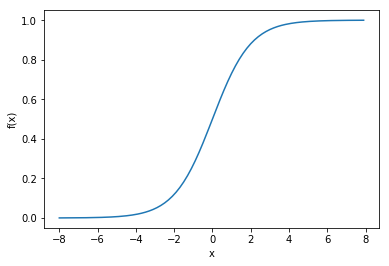

In [39]:
x = np.arange(-8, 8, 0.1)
f = 1 / (1 + np.exp(-x))
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

 the function is “activated” i.e. it moves from 0 to 1 when the input x is greater than a certain value. The sigmoid function isn’t a step function however, the edge is “soft”, and the output doesn’t change instantaneously. 

setup the sigmoid function and its derivative:

In [40]:
def f(x):
    return 1 / (1 + np.exp(-x))
def f_deriv(x):
    return f(x) * (1 - f(x))

biological neurons are connected hierarchical networks, with the outputs of some neurons being the inputs to others. We can represent these networks as connected layers of nodes. Each node takes multiple weighted inputs, applies the activation function to the summation of these inputs, and in doing so generates an output.

So the first step is to initialise the weights for each layer. 

To make it easy to organise the various layers, we’ll use Python dictionary objects (initialised by {}). Finally, the weights have to be initialised with random values – this is to ensure that the neural network will converge correctly during training. We use the numpy library random_sample function to do this. 

The weight initialisation code is shown below:

In [41]:
import numpy.random as r
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

Training constitutes setting of the values of the weights which link the layers in the network. In supervised learning, the idea is to reduce the error between the input and the desired output.

The idea of supervised learning is to provide many input-output pairs of known data and vary the weights based on these samples so that the error expression is minimised.

How do we know how to vary the weights, given an error in the output of the network? This is where the concept of gradient descent comes in handy. 

In [42]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

The first step is to perform a feed forward pass through the network.

This is how you calculate the output of the network when the input and the weights are known.

In [43]:
def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        # if it is the first layer, then the input into the weights is x, otherwise, 
        # it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l)) 
    return h, z

### Training the network

We're not setting a termination of the gradient descent process based on some change or precision of the cost function. Rather, we are just running it for a set number of iterations and we’ll monitor how the average cost function changes as we progress through the training (avg_cost_func list in the below code). 

In each iteration of the gradient descent, we cycle through each training sample (range(len(y)) and perform the feed forward pass and then the backpropagation. The backpropagation step is an iteration through the layers starting at the output layer and working backwards – range(len(nn_structure), 0, -1). 

We calculate the average cost, which we are tracking during the training, at the output layer (l == len(nn_structure)). 

We also update the mean accumulation values, ΔW and Δb, designated as tri_W and tri_b, for every layer apart from the output layer (there are no weights connecting the output layer to any further layer)

Finally, after we have looped through all the training samples, accumulating the tri_W and tri_b values, we perform a gradient descent step change in the weight and bias values

After the process is completed, we return the trained weight and bias values, along with our tracked average cost for each iteration.

In [44]:
def calculate_out_layer_delta(y, h_out, z_out):
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [45]:
def train_nn(nn_structure, X, y, iter_num=600, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%50 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, to be used in the
            # gradient descent step
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

In [46]:
alpha = 0.1 #learning rate
n_it = 1000 #number of iterations

Let's run the function

In [47]:
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, n_it, alpha)

Starting gradient descent for 1000 iterations
Iteration 0 of 1000


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Iteration 50 of 1000
Iteration 100 of 1000
Iteration 150 of 1000
Iteration 200 of 1000
Iteration 250 of 1000
Iteration 300 of 1000
Iteration 350 of 1000
Iteration 400 of 1000
Iteration 450 of 1000
Iteration 500 of 1000
Iteration 550 of 1000
Iteration 600 of 1000
Iteration 650 of 1000
Iteration 700 of 1000
Iteration 750 of 1000
Iteration 800 of 1000
Iteration 850 of 1000
Iteration 900 of 1000
Iteration 950 of 1000


Now we can have a look at how the average cost function decreased as we went through the gradient descent iterations of the training, slowly converging on a minimum in the function:

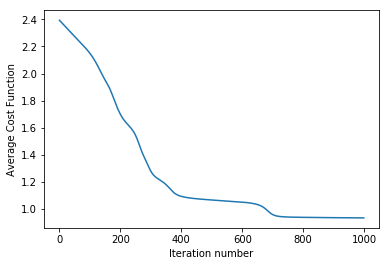

In [48]:
plt.plot(avg_cost_func)
plt.ylabel('Average Cost Function')
plt.xlabel('Iteration number')
plt.show()

our average cost function value has started to “plateau” and therefore any further increases in the number of iterations isn’t likely to improve the performance of the network by much.

### Evaluating the network

Given a test input (64x64 pixels), we need to find what the output of our neural network is – we do that by simply performing a feed forward pass through the network using our trained weight and bias values. As discussed previously, we assess the prediction of the output layer by taking the node with the maximum output as the predicted digit. We can use the numpy.argmax function for this, which returns the index of the array value with the highest value:

In [49]:
def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

In [50]:
from sklearn.metrics import accuracy_score
y_pred = predict_y(W, b, X_test, 3)
accuracy_score(y_test, y_pred)*100

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


19.75

classification accuracy is not great. We might achieve a better accuracy by
* increasing the number of iterations (find lower plateaus)
* decreasing the learning rate
* providing more examples of each category
* using a deeper network

## Building a neural network with tensorflow

In [51]:
import tensorflow as tf

In [65]:
# Parameters
learning_rate = 0.05
num_steps = 10000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = size**2 #image shape (256*256)
num_classes = 10

logs_path = '/tmp/tensorflow_logs/example/'

Create placeholders for inputs (X = image data, y = labels)

In [66]:
# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

Set up network weights and biases

In [67]:
# Store layers weight & bias# Store 
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [68]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [69]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

Train the model:

In [77]:
# Start training
A =[]
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for step in range(1, num_steps+1):
        ind = r.choice(np.arange(np.shape(X_train)[0]),batch_size)
        batch_x = X_train[ind]
        batch_y = y_v_train[ind]
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            A.append(acc)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_test, 
                                      Y: y_v_test})) 

Step 1, Minibatch Loss= 205919.1562, Training Accuracy= 0.172
Step 100, Minibatch Loss= 2655.8806, Training Accuracy= 0.375
Step 200, Minibatch Loss= 955.3306, Training Accuracy= 0.375
Step 300, Minibatch Loss= 1221.7792, Training Accuracy= 0.422
Step 400, Minibatch Loss= 8057.5283, Training Accuracy= 0.328
Step 500, Minibatch Loss= 9897.3408, Training Accuracy= 0.344
Step 600, Minibatch Loss= 1262.9666, Training Accuracy= 0.555
Step 700, Minibatch Loss= 371.0617, Training Accuracy= 0.656
Step 800, Minibatch Loss= 194.0653, Training Accuracy= 0.711
Step 900, Minibatch Loss= 41.4070, Training Accuracy= 0.773
Step 1000, Minibatch Loss= 89.5754, Training Accuracy= 0.766
Step 1100, Minibatch Loss= 21.3811, Training Accuracy= 0.789
Step 1200, Minibatch Loss= 81.2754, Training Accuracy= 0.836
Step 1300, Minibatch Loss= 970.8232, Training Accuracy= 0.578
Step 1400, Minibatch Loss= 16204.8311, Training Accuracy= 0.273
Step 1500, Minibatch Loss= 4583.0093, Training Accuracy= 0.430
Step 1600, Mi

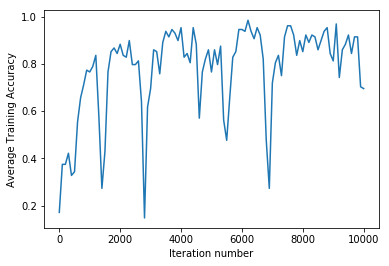

In [78]:
plt.plot(np.arange(0,num_steps+1, display_step), A)
plt.ylabel('Average Training Accuracy')
plt.xlabel('Iteration number')
plt.show()

In [79]:
##!tensorboard --logdir=/tmp/tensorflow_logs